<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/HAFSA_Atmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Retrieves HAFS-A data from AWS along a storm's track using files generated by getStormTrack.ipynb.

Set up environment

In [ ]:
!pip install cfgrib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.5 MB/s eta 0:00:00


In [136]:
from tropycal import tracks, rain
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib
import numpy as np

User parameters

In [ ]:
name = "Milton"
tcNum = "14"
filepath = f"/content/{name}"
trackType = "major"

Open TC Data

In [ ]:
tc = pd.read_csv(filepath + "/hurdat2_" + name + "_" + trackType + ".csv")

In [ ]:
tc

,Unnamed: 0,index,time,extra_obs,special,type,lat,lon,vmax,mslp,wmo_basin
0,0,11,2024-10-07 12:00:00,0,NaN,HU,21.8,-92.2,120,943,north_atlantic
1,1,12,2024-10-07 18:00:00,0,NaN,HU,21.7,-91.3,150,908,north_atlantic
2,2,13,2024-10-07 20:00:00,1,I,HU,21.8,-90.9,155,895,north_atlantic
3,3,14,2024-10-08 00:00:00,0,NaN,HU,21.8,-90.4,145,902,north_atlantic
4,4,15,2024-10-08 06:00:00,0,NaN,HU,21.9,-89.5,125,925,north_atlantic
5,5,16,2024-10-08 12:00:00,0,NaN,HU,22.5,-88.8,125,929,north_atlantic
6,6,17,2024-10-08 18:00:00,0,NaN,HU,22.5,-88.0,140,916,north_atlantic
7,7,18,2024-10-08 22:05:00,1,R,HU,22.8,-87.2,145,902,north_atlantic
8,8,19,2024-10-09 00:00:00,0,NaN,HU,23.0,-86.9,140,908,north_atlantic
9,9,20,2024-10-09 02:05:00,1,R,HU,23.3,-86.6,135,916,north_atlantic


Retrieve HAFS-A Atmospheric Data

In [ ]:
#Sample URL: https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/13l.2024100712.hfsa.mom6.f000.nc
#            https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/13l.2024100712.hfsa.parent.atm.

bucket = "https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/"

In [112]:
stormMSLP = {} #Stores pressure along TC track
parentMSLP = {}

In [138]:
dateFormat = "%Y-%m-%d %H:%M:%S"

start = tc.time[0]
startDate, startTime = start.split(" ")
startYear, startMonth, startDay = startDate.split("-")
startHour, startMinute, startSecond = startTime.split(":")

for row in tc.iloc:
  rowTime = dt.strptime(row.time, dateFormat)
  if rowTime.hour % 3 != 0 or rowTime.minute != 0: continue #Skip any lines that don't have a HAFS forecast at the same time

  tDiff = rowTime - dt.strptime(start, dateFormat)
  fHour = str(int(tDiff.total_seconds() / 3600))
  while len(fHour) < 3: fHour = "0" + fHour

  parentURL = bucket + startDate.replace("-", "") + "/" + startHour + "/" + tcNum + "l." + startDate.replace("-", "") + startHour + ".hfsa.parent.atm.f" + fHour + ".grb2"
  stormURL = bucket + startDate.replace("-", "") + "/" + startHour + "/" + tcNum + "l." + startDate.replace("-", "") + startHour + ".hfsa.storm.atm.f" + fHour + ".grb2"

  !wget -O parentData.grb2 {parentURL}
  !wget -O stormData.grb2 {stormURL}

  stormData = xr.open_dataset("stormData.grb2", engine="cfgrib", decode_timedelta=True, filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'meanSea'})
  parentData = xr.open_dataset("parentData.grb2", engine="cfgrib", decode_timedelta=True, filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'meanSea'})

  #print("\n", row.lat)
  #print(float(stormData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon, method="nearest").latitude.data))
  #print(float(parentData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon, method="nearest").latitude.data))

  #print("\n", row.lon+360)
  #print(float(stormData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon+360, method="nearest").longitude.data))
  #print(float(parentData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon+360, method="nearest").longitude.data))

  #stormMSLP[row.time] = float(stormData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon+360, method="nearest").prmsl.data)/100
  #parentMSLP[row.time] = float(parentData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon+360, method="nearest").prmsl.data)/100

  parentMSLP[row.time] = np.min(parentData.prmsl.data[np.isnan(parentData.prmsl.data)==False]) / 100 #Convert from Pa to hPa
  stormMSLP[row.time] = np.min(stormData.prmsl.data[np.isnan(stormData.prmsl.data)==False]) / 100
  print("Best:", row.mslp, "\nParent: ", parentMSLP[row.time], "\nStorm: ", stormMSLP[row.time])

--2025-06-06 20:41:58--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/14l.2024100712.hfsa.parent.atm.f000.grb2
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 52.217.117.161, 3.5.29.249, 52.217.0.148, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|52.217.117.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 837674250 (799M) [application/octet-stream]
Saving to: ‘parentData.grb2’

parentData.grb2     100%[===================>] 798.87M  56.2MB/s    in 12s     

2025-06-06 20:42:11 (66.4 MB/s) - ‘parentData.grb2’ saved [837674250/837674250]

--2025-06-06 20:42:11--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/14l.2024100712.hfsa.storm.atm.f000.grb2
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 52.217.120.1, 52.217.108.132, 3.5.25.228, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazo

In [126]:
parentMSLP

{'2024-10-07 12:00:00': 941.108359375,
 '2024-10-07 18:00:00': 945.0503125,
 '2024-10-08 00:00:00': 973.64203125,
 '2024-10-08 06:00:00': 980.54546875,
 '2024-10-08 12:00:00': 980.36890625,
 '2024-10-08 18:00:00': 985.36578125,
 '2024-10-09 00:00:00': 979.26,
 '2024-10-09 06:00:00': 950.652421875,
 '2024-10-09 12:00:00': 978.45734375,
 '2024-10-09 18:00:00': 980.340234375,
 '2024-10-10 00:00:00': 989.01375}

In [127]:
stormMSLP

{'2024-10-07 12:00:00': 1005.036328125,
 '2024-10-07 18:00:00': 1000.8384375,
 '2024-10-08 00:00:00': 974.999765625,
 '2024-10-08 06:00:00': 992.677734375,
 '2024-10-08 12:00:00': 997.108125,
 '2024-10-08 18:00:00': 999.0425,
 '2024-10-09 00:00:00': 1001.07125,
 '2024-10-09 06:00:00': 1004.364765625,
 '2024-10-09 12:00:00': 1006.867265625,
 '2024-10-09 18:00:00': 1010.13546875,
 '2024-10-10 00:00:00': nan}

Create MSLP Figure

In [146]:
modelDates = [dt.strptime(datetime, dateFormat) for datetime in parentMSLP.keys()]
btDates = [dt.strptime(datetime, dateFormat) for datetime in tc.time]

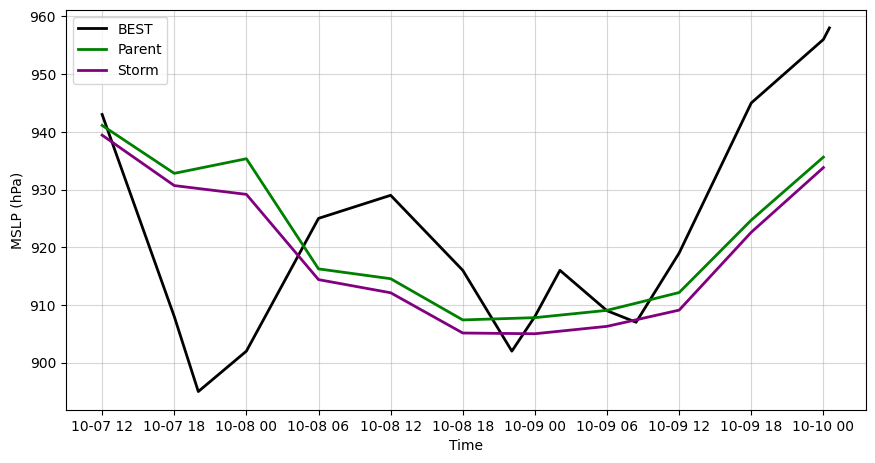

In [148]:
mslpFig = plt.figure(figsize=(10, 5))
mslpAx = mslpFig.add_axes([0.1,0.1,0.8,0.8])

mslpAx.plot(btDates, tc.mslp, label="BEST", color="black", linewidth=2)
mslpAx.plot(modelDates, parentMSLP.values(), label="Parent", color="green", linewidth=2)
mslpAx.plot(modelDates, stormMSLP.values(), label="Storm", color="purple", linewidth=2)

mslpAx.set_xlabel("Time")
mslpAx.set_ylabel("MSLP (hPa)")
mslpAx.grid(alpha=0.5)
mslpAx.legend()

mslpFig.savefig(filepath + "/mslp.png")

Calculate RMSE